In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
import warnings
warnings.filterwarnings('ignore')
import csv
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss, make_scorer, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.multiclass import OneVsRestClassifier

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

RuntimeError: ignored

RuntimeError: ignored

RuntimeError: ignored

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/assignment1_colab/Telstra Case Study

/content/drive/MyDrive/assignment1_colab/Telstra Case Study


In [4]:
train_data = pd.read_csv('train.csv',index_col='id')
test_data = pd.read_csv('test.csv',index_col='id')
event_type = pd.read_csv('event_type.csv')
log_feature = pd.read_csv('log_feature.csv')
resource_type = pd.read_csv('resource_type.csv')
severity_type = pd.read_csv('severity_type.csv')

In [5]:
train_data_copy = train_data.copy()
test_data_copy = test_data.copy()
event_type_copy = event_type.copy()
log_feature_copy = log_feature.copy()
resource_type_copy = resource_type.copy()
severity_type_copy = severity_type.copy()

In [6]:
train_data = train_data.reset_index()
test_data = test_data.reset_index()

In [7]:
# append train & test
# ---------------------------------------------------------------------------------
train_data['location_id'] = train_data.location.apply(lambda x: int(x.split('location ')[1]))
test_data['location_id'] = test_data.location.apply(lambda x: int(x.split('location ')[1]))

print('train', train_data.shape, 'test', test_data.shape)

train (7381, 4) test (11171, 3)


In [8]:
event_type['event_type'] = event_type['event_type'].map(lambda x: int(x.split(' ')[1]))
#event_type = pd.get_dummies(event_type, columns=['event_type'],dtype=np.int64) # get dummy variables for event type
event_type = event_type.groupby(event_type.id,as_index=False).sum() # compact the rows with the same id

In [9]:
# 2.1. Left join training/test set <-> event_type set
X = pd.merge(left=train_data, right=event_type, how='left', left_on='id', right_on='id')
Y = pd.merge(left=test_data, right=event_type, how='left', left_on='id', right_on='id')

In [10]:
X.head(2)

id      location  fault_severity  location_id  event_type
0  14121  location 118               1          118          69
1   9320   location 91               0           91          69

In [11]:
resource_type['resource_type'] = resource_type['resource_type'].map(lambda x: int(x.split(' ')[1]))
#resource_type = pd.get_dummies(resource_type, columns=['resource_type'],dtype=np.int64)
resource_type = resource_type.groupby(resource_type.id,as_index=False).sum()

In [12]:
# 2.1. Left join training/test set <-> event_type set
X = pd.merge(left=X, right=resource_type, how='left', left_on='id', right_on='id')
Y = pd.merge(left=Y, right=resource_type, how='left', left_on='id', right_on='id')

In [13]:
severity_type['severity_type'] = severity_type['severity_type'].map(lambda x: int(x.split(' ')[1]))
#severity_type = pd.get_dummies(severity_type, columns=['severity_type'],dtype=np.int64)
severity_type = severity_type.groupby(severity_type.id,as_index=False).sum()

In [14]:
# 2.1. Left join training/test set <-> event_type set
X = pd.merge(left=X, right=severity_type, how='left', left_on='id', right_on='id')
Y = pd.merge(left=Y, right=severity_type, how='left', left_on='id', right_on='id')

In [15]:
log_feature['feature_type'] = log_feature['log_feature'].map(lambda x: int(x.split(' ')[1]))
#log_feature = pd.get_dummies(log_feature, columns=['log_feature'],dtype=np.int64)
log_feature = log_feature.groupby(log_feature.id,as_index=False).sum()

In [16]:
# 2.1. Left join training/test set <-> event_type set
X = pd.merge(left=X, right=log_feature, how='left', left_on='id', right_on='id')
Y = pd.merge(left=Y, right=log_feature, how='left', left_on='id', right_on='id')

In [17]:
X = X.drop('location',axis=1)
Y = Y.drop('location',axis=1)

In [18]:
print('train', X.shape, 'test', Y.shape)

train (7381, 8) test (11171, 7)


In [19]:
# create a transformer for the categorical values
#categorical_transformer = Pipeline(steps=[
    #('one_hot', OneHotEncoder(handle_unknown='ignore'))])

In [20]:
log_feature_copy.head(2)

id log_feature  volume
0  6597  feature 68       6
1  8011  feature 68       7

In [21]:
# merge log features
log_vol = log_feature_copy.groupby('id')['volume'].agg(['count','min', 'mean', 'max', 'std', 'sum']).fillna(0).add_prefix('log_volume')

In [22]:
log_vol.head(2)

log_volumecount  log_volumemin  ...  log_volumestd  log_volumesum
id                                  ...                              
1                 3              1  ...        0.57735              5
2                 5              1  ...        0.00000              5

[2 rows x 6 columns]

In [23]:
log_vol = log_vol.reset_index()

In [24]:
log_vol.head(2)

id  log_volumecount  ...  log_volumestd  log_volumesum
0   1                3  ...        0.57735              5
1   2                5  ...        0.00000              5

[2 rows x 7 columns]

In [25]:
# 2.1. Left join training/test set <-> event_type set
X = pd.merge(left=X, right=log_vol, how='left', left_on='id', right_on='id')
Y = pd.merge(left=Y, right=log_vol, how='left', left_on='id', right_on='id')

In [26]:
X

id  fault_severity  ...  log_volumestd  log_volumesum
0     14121               1  ...       0.000000             38
1      9320               0  ...      59.396970            316
2     14394               1  ...       0.000000              2
3      8218               1  ...       5.686241             22
4     14804               0  ...       0.500000             12
...     ...             ...  ...            ...            ...
7376    870               0  ...       0.000000              2
7377  18068               0  ...       0.000000              2
7378  14111               2  ...       9.899495             28
7379  15189               0  ...       8.139410             33
7380  17067               0  ...       0.000000              3

[7381 rows x 14 columns]

In [27]:
event_type_copy.head(2)

id     event_type
0  6597  event_type 11
1  8011  event_type 15

In [28]:
#newly added
event_type_copy['event_id'] = event_type_copy.event_type.apply(lambda x: int(x.split('event_type ')[1]))

In [29]:
event_type_copy.head(2)

id     event_type  event_id
0  6597  event_type 11        11
1  8011  event_type 15        15

In [30]:
X1 = X.copy()
Y1 = Y.copy()

In [31]:
# 2.1. Left join training/test set <-> event_type set
logev_X = pd.merge(left=log_feature_copy, right=event_type_copy, how='left', left_on='id', right_on='id')
logev_Y = pd.merge(left=log_feature_copy, right=event_type_copy, how='left', left_on='id', right_on='id')

In [32]:
ev_X = logev_X.copy()
ev_Y = logev_Y.copy()

In [33]:
logev_X.head(2)

id log_feature  volume     event_type  event_id
0  6597  feature 68       6  event_type 11        11
1  8011  feature 68       7  event_type 15        15

In [34]:
event_type_copy.shape

(31170, 3)

In [35]:
# merge log features
logev_volx = logev_X.groupby('id')['volume'].agg(['count','min', 'mean', 'max', 'std', 'sum']).fillna(0).add_prefix('event_volume')
logev_voly = logev_Y.groupby('id')['volume'].agg(['count','min', 'mean', 'max', 'std', 'sum']).fillna(0).add_prefix('event_volume')

In [36]:
logev_volx = logev_volx.reset_index()
logev_voly = logev_voly.reset_index()

In [37]:
logev_volx.head(2)

id  event_volumecount  ...  event_volumestd  event_volumesum
0   1                  6  ...         0.516398               10
1   2                 10  ...         0.000000               10

[2 rows x 7 columns]

In [38]:
# 2.1. Left join training/test set <-> event_type set
X1 = pd.merge(left=X1, right=logev_volx, how='inner', left_on='id', right_on='id')
Y1 = pd.merge(left=Y1, right=logev_voly, how='inner', left_on='id', right_on='id')

In [39]:
X1.head(2)

id  fault_severity  ...  event_volumestd  event_volumesum
0  14121               1  ...         0.000000               76
1   9320               0  ...        48.497423              632

[2 rows x 20 columns]

In [40]:
X2 = X1.copy()
Y2 = Y1.copy()

In [41]:
severity_type_copy.head(2)

id    severity_type
0  6597  severity_type 2
1  8011  severity_type 2

In [42]:
#newly added
severity_type_copy['sev_id'] = severity_type_copy.severity_type.apply(lambda x: int(x.split('severity_type ')[1]))

In [43]:
severity_type_copy.head(2)

id    severity_type  sev_id
0  6597  severity_type 2       2
1  8011  severity_type 2       2

In [44]:
# 2.1. Left join training/test set <-> event_type set
sev_X = pd.merge(left=log_feature_copy, right=severity_type_copy, how='left', left_on='id', right_on='id')
sev_Y = pd.merge(left=log_feature_copy, right=severity_type_copy, how='left', left_on='id', right_on='id')

In [45]:
sev_X.head(2)

id log_feature  volume    severity_type  sev_id
0  6597  feature 68       6  severity_type 2       2
1  8011  feature 68       7  severity_type 2       2

In [46]:
# merge log features
sev_volx = sev_X.groupby('id')['volume'].agg(['count','min', 'mean', 'max', 'std', 'sum']).fillna(0).add_prefix('sev_volume')
sev_voly = sev_Y.groupby('id')['volume'].agg(['count','min', 'mean', 'max', 'std', 'sum']).fillna(0).add_prefix('sev_volume')

In [47]:
sev_volx = sev_volx.reset_index()
sev_voly = sev_voly.reset_index()

In [48]:
# 2.1. Left join training/test set <-> event_type set
X2 = pd.merge(left=X2, right=sev_volx, how='inner', left_on='id', right_on='id')
Y2 = pd.merge(left=Y2, right=sev_voly, how='inner', left_on='id', right_on='id')

In [49]:
print(X2.shape,Y2.shape)

(7381, 26) (11171, 25)


In [50]:
X2.head(2)

id  fault_severity  ...  sev_volumestd  sev_volumesum
0  14121               1  ...        0.00000             38
1   9320               0  ...       59.39697            316

[2 rows x 26 columns]

In [51]:
X3 = X2.copy()
Y3 = Y2.copy()

In [52]:
#X2 = X2.drop_duplicates('id', keep='last')

In [53]:
#Y2 = Y2.drop_duplicates('id', keep='last')

In [54]:
# Python log transform
X3.insert(len(X3.columns), 'log_volume',np.log(X3['volume']))
Y3.insert(len(Y3.columns), 'log_volume',np.log(Y3['volume']))

In [55]:
X3.head(2)

id  fault_severity  location_id  ...  sev_volumestd  sev_volumesum  log_volume
0  14121               1          118  ...        0.00000             38    3.637586
1   9320               0           91  ...       59.39697            316    5.755742

[2 rows x 27 columns]

In [56]:
X3["avgvol_per_loc"]= X3.groupby(['location_id'])["log_volume"].transform('mean')
X3["maxvol_per_loc"]= X3.groupby(['location_id'])["log_volume"].transform('max')
X3["minvol_per_loc"]= X3.groupby(['location_id'])["log_volume"].transform('min')
X3["medianvol_per_loc"]= X3.groupby(['location_id'])["log_volume"].transform('median')
X3["stdvol_per_loc"] = X3.groupby(['location_id'])["log_volume"].transform('std')

Y3["avgvol_per_loc"]= Y3.groupby(['location_id'])["log_volume"].transform('mean')
Y3["maxvol_per_loc"]= Y3.groupby(['location_id'])["log_volume"].transform('max')
Y3["minvol_per_loc"]= Y3.groupby(['location_id'])["log_volume"].transform('min')
Y3["medianvol_per_loc"]= Y3.groupby(['location_id'])["log_volume"].transform('median')
Y3["stdvol_per_loc"] = Y3.groupby(['location_id'])["log_volume"].transform('std')

In [57]:
X3.head(2)

id  fault_severity  ...  medianvol_per_loc  stdvol_per_loc
0  14121               1  ...           3.401197        0.873569
1   9320               0  ...           5.068904        1.807306

[2 rows x 32 columns]

**Add new features**

In [58]:
severity_type_copy.head(2)

id    severity_type  sev_id
0  6597  severity_type 2       2
1  8011  severity_type 2       2

In [59]:
# order ~ time
# ---------------------------------------------------------------------------------
severity_type_order = severity_type_copy[['id']].drop_duplicates()
severity_type_order['order'] = 1. * np.arange(len(severity_type_order)) / len(severity_type_order)

In [60]:
X3 = pd.merge(left=X3, right=severity_type_order, how='inner', on='id')
Y3 = pd.merge(left=Y3, right=severity_type_order, how='inner', on='id')

In [61]:
print(X3.shape,Y3.shape)

(7381, 33) (11171, 32)


In [62]:
# order ~ time
# ---------------------------------------------------------------------------------
event_type_order = event_type_copy[['id']].drop_duplicates()
event_type_order['event_order'] = 1. * np.arange(len(event_type_order)) / len(event_type_order)

In [63]:
X3 = pd.merge(left=X3, right=event_type_order, how='inner', on='id')
Y3 = pd.merge(left=Y3, right=event_type_order, how='inner', on='id')

In [64]:
# order ~ time
# ---------------------------------------------------------------------------------
log_feature_order = log_feature_copy[['id']].drop_duplicates()
log_feature_order['feature_order'] = 1. * np.arange(len(log_feature_order)) / len(log_feature_order)

In [65]:
X3 = pd.merge(left=X3, right=log_feature_order, how='inner', on='id')
Y3 = pd.merge(left=Y3, right=log_feature_order, how='inner', on='id')

In [66]:
print(X3.shape,Y3.shape)

(7381, 35) (11171, 34)


In [67]:
# rank location features by ascneding and descending orders
# ---------------------------------------------------------------------------------
X3['location_rank_asc'] = X3.groupby('location_id')[['order']].rank()
X3['location_rank_desc'] = X3.groupby('location_id')[['order']].rank(ascending=False)

# ---------------------------------------------------------------------------------
Y3['location_rank_asc'] = Y3.groupby('location_id')[['order']].rank()
Y3['location_rank_desc'] = Y3.groupby('location_id')[['order']].rank(ascending=False)

In [68]:
location_count_tr = train_data.groupby('location_id').count()[['id']]
location_count_tr.columns = ['location_count']

location_count_te = test_data.groupby('location_id').count()[['id']]
location_count_te.columns = ['location_count']

In [69]:
# 2.1. Left join training/test set <-> event_type set
X3 = pd.merge(left=X3, right=location_count_tr, how='left', left_on='location_id', right_on='location_id')
Y3 = pd.merge(left=Y3, right=location_count_te, how='left', left_on='location_id', right_on='location_id')

In [70]:
X3['loc_rank_rel'] = 1. * X3['location_rank_asc'] / X3['location_count']
X3['loc_rank_rel'] = np.round(X3['loc_rank_rel'], 2)

Y3['loc_rank_rel'] = 1. * Y3['location_rank_asc'] / Y3['location_count']
Y3['loc_rank_rel'] = np.round(Y3['loc_rank_rel'], 2)

In [71]:
X_df = X3.copy()
Y_df = Y3.copy()

In [72]:
print(X_df.shape,Y_df.shape)

(7381, 39) (11171, 38)


In [73]:
index = Y3['id']
Y3['id'] = index

In [74]:
X = X3.set_index('id')
Y = Y3.set_index('id')

In [75]:
print(X.shape,Y.shape)

(7381, 38) (11171, 37)


In [76]:
X = X.drop(['fault_severity'], axis=1)

In [77]:
X.columns

Index(['location_id', 'event_type', 'resource_type', 'severity_type', 'volume',
       'feature_type', 'log_volumecount', 'log_volumemin', 'log_volumemean',
       'log_volumemax', 'log_volumestd', 'log_volumesum', 'event_volumecount',
       'event_volumemin', 'event_volumemean', 'event_volumemax',
       'event_volumestd', 'event_volumesum', 'sev_volumecount',
       'sev_volumemin', 'sev_volumemean', 'sev_volumemax', 'sev_volumestd',
       'sev_volumesum', 'log_volume', 'avgvol_per_loc', 'maxvol_per_loc',
       'minvol_per_loc', 'medianvol_per_loc', 'stdvol_per_loc', 'order',
       'event_order', 'feature_order', 'location_rank_asc',
       'location_rank_desc', 'location_count', 'loc_rank_rel'],
      dtype='object')

In [78]:
y = X_df['fault_severity']

In [79]:
print(X.shape,Y.shape)

(7381, 37) (11171, 37)


In [80]:
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train,X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

In [81]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

In [82]:
# import the needed libraries first
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer

In [83]:
# create a transformed for the numerical values
numeric_transformer_std = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler',StandardScaler())])

from sklearn.compose import ColumnTransformer

preprocessor_sca_std = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_std, numeric_features),
        #('cat', categorical_transformer, categorical_features)
    ])

In [84]:
#We are then ready to transform!
X_train_transformed_sca1 = preprocessor_sca_std.fit_transform(X_train)
X_test_transformed_sca1 = preprocessor_sca_std.transform(X_test)
X_train_transformed_sca_copy = X_train_transformed_sca1.copy()
test_transformed_sca1 = preprocessor_sca_std.transform(Y)

X_train_sca = pd.DataFrame(X_train_transformed_sca1)
X_test_sca = pd.DataFrame(X_test_transformed_sca1)
test_sca = pd.DataFrame(test_transformed_sca1)

In [85]:
print(X.shape,X_train_sca.shape)

(7381, 37) (5904, 37)


In [86]:
# Imputation removed column names; put them back
X_train_sca.columns = X.columns
X_test_sca.columns = X.columns

In [103]:
test_sca.columns = Y.columns

In [87]:
from sklearn.metrics import f1_score
import sklearn.metrics as metrics

In [93]:
models2 =[]
f1score = []
classifier_names = ['KNN','Random Forest','Logistic Regression','DTC','SVC', 'XGB', 'LGBM','GBC']
classifiers = [KNeighborsClassifier(),
               RandomForestClassifier(),
               DecisionTreeClassifier(),
               LogisticRegression(multi_class='ovr'),
               OneVsRestClassifier(SVC()),
               OneVsRestClassifier(XGBClassifier()),
               lgb.LGBMClassifier(),
               GradientBoostingClassifier()]

In [ ]:
for i in classifiers:
    model = i
    cv_result = cross_val_score(model,X=X_train_sca, y=y_train, cv=5, scoring='f1_macro').mean()
    cv_result=cv_result
    models2.append(cv_result.mean())
    f1score.append(cv_result)

cv_models_dataframe = pd.DataFrame(models2, index=classifier_names)   
cv_models_dataframe.columns=['CV Mean']    
cv_models_dataframe
cv_models_dataframe.sort_values(['CV Mean'], ascending=[0])

[13:43:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:43:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:43:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:43:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

CV Mean
LGBM                 0.710552
XGB                  0.700306
GBC                  0.690926
Random Forest        0.687756
Logistic Regression  0.625770
KNN                  0.593977
SVC                  0.519282
DTC                  0.486566

In [88]:
X4 = preprocessor_sca_std.fit_transform(X)
Y4 = preprocessor_sca_std.transform(Y)

X5 = pd.DataFrame(X4)
Y5 = pd.DataFrame(Y4)

In [106]:
lgbm = lgb.LGBMClassifier()
lgbm.fit(X_train_sca,y_train)

LGBMClassifier()

In [97]:
# Notice the model makes a fair number of errors
print("number of errors on test dataset: " + str(sum(lgbm.predict(X_test_sca) != y_test)))

number of errors on test dataset: 301


In [134]:
loss2tr2 = log_loss(y_train.values, lgbm.predict_proba(X_train_sca))
print("LGBM: train loss {:.4f}".format(loss2tr2))
print('---------------------------------------------------------------')
loss2te2 = log_loss(y_test.values, lgbm.predict_proba(X_test_sca))
print("LGBM: test loss {:.4f}".format(loss2te2))

LGBM: train loss 0.2472
---------------------------------------------------------------
LGBM: test loss 0.4658


In [135]:
#Predictions
y_pred = lgbm.predict(X_test_sca)
report9 = classification_report(y_test,y_pred,output_dict=True)
df_std = pd.DataFrame(report9).transpose()

In [136]:
df_std

precision    recall  f1-score      support
0              0.854437  0.895507  0.874490   957.000000
1              0.663551  0.568000  0.612069   375.000000
2              0.673203  0.710345  0.691275   145.000000
accuracy       0.794177  0.794177  0.794177     0.794177
macro avg      0.730397  0.724617  0.725945  1477.000000
weighted avg   0.788180  0.794177  0.789876  1477.000000

In [ ]:
predict_test = lgbm.predict_proba(test_sca)
pred_df2 = pd.DataFrame(predict_test,columns=['predict_0', 'predict_1', 'predict_2'])
Y3 = Y.reset_index()
results2 = pd.concat([Y3[['id']],pred_df2],axis=1)
results2 = results2.set_index('id')  # set ID as index
results2.head()

predict_0  predict_1  predict_2
id                                    
11066   0.992796   0.006920   0.000284
18000   0.096643   0.101701   0.801656
16964   0.990135   0.009582   0.000283
4795    0.727110   0.272144   0.000745
3392    0.138893   0.823586   0.037521

In [ ]:
results2.to_csv('lggbmm1.csv')

In [ ]:
#y_test =  y_test.values
y_pred = lgbm.predict(X_test_sca)

https://www.analyticsvidhya.com/blog/2021/06/confusion-matrix-for-multi-class-classification/

In [ ]:
# Creating  a confusion matrix,which compares the y_test and y_pred
cm = confusion_matrix(y_test, y_pred)
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm, index = ['Fault 0','Fault 1','Fault 2'], columns = ['Fault 0','Fault 1','Fault 2'])

#Plotting the confusion matrix
plt.figure(figsize=(8,4))
sns.heatmap(cm_df, annot=True,cbar=True, fmt='g')

plt.xlabel('Predicted Values')
plt.ylabel('Actal Values')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
cm_df 

Fault 0  Fault 1  Fault 2
Fault 0      883       67        7
Fault 1      121      224       30
Fault 2       22       26       97

We can see from below confusion matrix that,

For example, if we take class Fault sev- 2, then let’s see what are the values of the metrics from the confusion matrix.

A) TP = 97

B) TN = 121 + 224 + 883 + 67

C) FN = 22 + 26 (For Fault sev -2 out of 145 test data points, our model is able to predict( 66.89% of test points as fault severity 2)

D) FP --> 30 + 7 



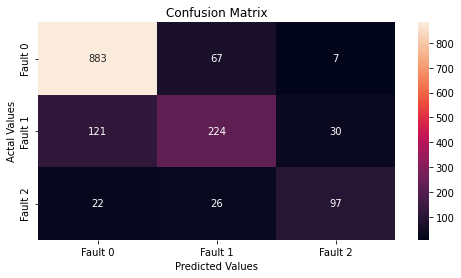

In [ ]:
#Plotting the confusion matrix
plt.figure(figsize=(8,4))
sns.heatmap(cm_df, annot=True,cbar=True, fmt='g')

plt.xlabel('Predicted Values')
plt.ylabel('Actal Values')
plt.title('Confusion Matrix')
plt.show()

In [115]:
pip install kds

In [87]:
import kds
kds.metrics.report(y_test, y_pred)

NameError: ignored

Let us understand each of these plots. Please note that the x-axis of all the plots is Deciles.


**Gain Chart:**

For example,  77% of targets(fault severity) covered in top 30% of data based on model. In our case of detecting the fault severity by model, we can say that the model can identify 77% of fault severity by focusing on top 30% of test data or by focusin on top 30% of locations(as faults are detected at particular location) 

**Lift Plot:** 

Lift measures how much better one can expect to do with the predictive model comparing without a model.(This plot shows us how much better is LGBM Classification model is compared to the random model at all.)

 Eg: decile 2 gives us a lift almost 3.6 times meaning we can do 3.6 times better than the random model approach. Meaning that or model is able to detect faults 3.6 times better than random model.
 
  As we go to higher deciles the lift drops and eventually meets the random model line, this is because all the higher probability score values are in the top deciles (1 to 3).

**Decile-wise Lift Plot:**

This plot shows us the percentage of the target class observation in each of the deciles and we observe that decile 1 had maximum and as we go higher deciles the percentage drops and after a certain point it even goes below random model line.

**KS Statistic Plot:**

The KS plot evaluates different distributions i.e events and non-events and the KS value is a point where the difference is maximum between the distributions. KS Statistc Plot helps us in understanding the ability of the ML model to differentiate between two events. 

If(KS > 40 and if it happens to be in the top 3 deciles)
then:----> Model is considered to be good. In our case, we have a score of 
66.253 and decile 3 from the plot.



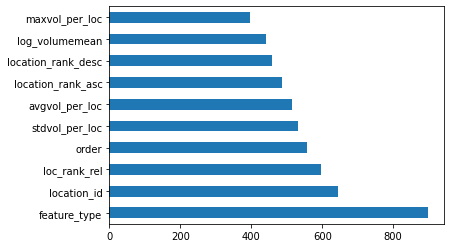

In [ ]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(lgbm.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

**Training LGBM Model using top features**

In [ ]:
X2 = X[['volume' , 'log_volumemean' , 'event_volumemean', 'location_rank_asc','location_rank_desc','avgvol_per_loc','location_id','order','stdvol_per_loc','loc_rank_rel']]
y2 = X_df['fault_severity']
Y2 = Y[['volume' , 'log_volumemean' , 'event_volumemean', 'location_rank_asc','location_rank_desc','avgvol_per_loc','location_id','order','stdvol_per_loc','loc_rank_rel']]

In [ ]:
numeric_features2 = X2.select_dtypes(include=['int64', 'float64']).columns

In [ ]:
# create a transformed for the numerical values
numeric_transformer_std2 = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler',StandardScaler())])

from sklearn.compose import ColumnTransformer

preprocessor_sca_std2 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_std2, numeric_features2),
        #('cat', categorical_transformer, categorical_features2)
    ])

In [ ]:
X_train2 , X_test2 , y_train2 , y_test2 = train_test_split(X2,y2,test_size = 0.2)

In [ ]:
#We are then ready to transform!
X_train_transformed_sca2 = preprocessor_sca_std2.fit_transform(X_train2)
X_test_transformed_sca2 = preprocessor_sca_std2.transform(X_test2)
X_train_transformed_sca_copy = X_train_transformed_sca2.copy()
test_transformed_sca2 = preprocessor_sca_std2.transform(Y2)

In [ ]:
X_train_sca2 = pd.DataFrame(X_train_transformed_sca2)
X_test_sca2 = pd.DataFrame(X_test_transformed_sca2)
test_sca2 = pd.DataFrame(test_transformed_sca2)

In [ ]:
models1 = []
for i in classifiers:
    model = i
    model.fit(X_train_sca2,y_train2)
    y_pred2 = model.predict(X_test_sca2)
    models1.append(metrics.f1_score(y_test,y_pred2,average='macro'))
models_dataframe1=pd.DataFrame(models1,index=classifier_names)   
models_dataframe1.columns=['F1 macro']
models_dataframe1.sort_values(['F1 macro'], ascending=[0])

[13:30:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:30:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:30:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


F1 macro
XGB                  0.341370
KNN                  0.337350
GBC                  0.336619
Random Forest        0.334391
LGBM                 0.332357
Logistic Regression  0.319209
DTC                  0.289590
SVC                  0.288776

So b using only selected features thereis so muchloss of data, hence the F1 score has decreased drastically

***Feature Selection -1 ***

SelectFromModel from Scikit-Learn is based on a Machine Learning Model estimation for selecting the features

In [ ]:
from sklearn.feature_selection import SelectFromModel

In [ ]:
selector = SelectFromModel(estimator=lgb.LGBMClassifier()).fit(X_train_sca, y_train)

In [ ]:
select_X_train = selector.transform(X_train_sca.values)
select_X_test = selector.transform(X_test_sca.values)

In [ ]:
lgbm_imp = lgb.LGBMClassifier()
lgbm_imp.fit(select_X_train,y_train) 

LGBMClassifier()

In [ ]:
#Predictions
y_pred = lgbm_imp.predict(select_X_test)
report9 = classification_report(y_test,y_pred,output_dict=True)
df_std = pd.DataFrame(report9).transpose()

In [ ]:
df_std

precision    recall  f1-score      support
0              0.835071  0.920585  0.875746   957.000000
1              0.679181  0.530667  0.595808   375.000000
2              0.744186  0.662069  0.700730   145.000000
accuracy       0.796209  0.796209  0.796209     0.796209
macro avg      0.752813  0.704440  0.724095  1477.000000
weighted avg   0.786569  0.796209  0.787490  1477.000000

In [ ]:
loss2tr = log_loss(y_train.values, lgbm_imp.predict_proba(select_X_train))
print("LGBM: train loss {:.4f}".format(loss2tr))
print('---------------------------------------------------------------')
loss2te = log_loss(y_test.values, lgbm_imp.predict_proba(select_X_test))
print("LGBM: test loss {:.4f}".format(loss2te))

LGBM: train loss 0.2158
---------------------------------------------------------------
LGBM: test loss 0.4752


In [ ]:
results2.to_csv('lgbmNohyp_new.csv')

In [ ]:
# Save the model
import pickle 
# save the model to disk
path = ' '
modelname = path + 'lgbmmodel.pkl'
pickle.dump(lgbm, open(modelname, 'wb'))

In [ ]:
# load the model from disk
loaded_model = pickle.load(open(modelname, 'rb'))
predictions = loaded_model.predict(test_sca[0:1])
predictions

**Variance Thresold Feature Extraction : Removing features with low variance**

In [88]:
from sklearn.feature_selection import VarianceThreshold

In [89]:
sel_variance_threshold = VarianceThreshold() 
X_train_remove_variance = sel_variance_threshold.fit_transform(X_train_sca)
print(X_train_remove_variance.shape)

(5904, 37)


In [90]:
X_test_remove_variance = sel_variance_threshold.transform(X_test_sca)

In [91]:
test_var = sel_variance_threshold.transform(test_sca)

In [94]:
models3 = []
f1score3 = []
for i in classifiers:
    model = i
    cv_result = cross_val_score(model,X=X_train_remove_variance, y=y_train, cv=5, scoring='f1_macro').mean()
    cv_result=cv_result
    models3.append(cv_result.mean())
    f1score3.append(cv_result)

cv_models_dataframe = pd.DataFrame(models3, index=classifier_names)   
cv_models_dataframe.columns=['CV Mean']    
cv_models_dataframe
cv_models_dataframe.sort_values(['CV Mean'], ascending=[0])

CV Mean
LGBM                 0.711202
Random Forest        0.689524
GBC                  0.688650
XGB                  0.677675
Logistic Regression  0.637718
KNN                  0.589249
SVC                  0.528735
DTC                  0.491142

In [95]:
lgbm_var = lgb.LGBMClassifier()
# Train the new classifier on the new dataset containing the most important features
lgbm_var.fit(X_train_remove_variance, y_train)

LGBMClassifier()

In [96]:
#Predictions
y_pred2 = lgbm_var.predict(X_test_remove_variance)

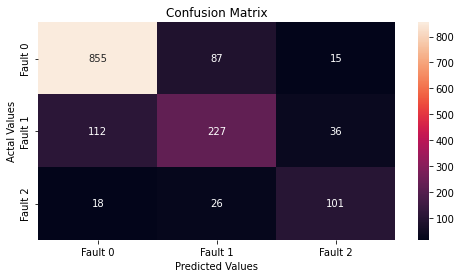

In [97]:
# Creating  a confusion matrix,which compares the y_test and y_pred
cm = confusion_matrix(y_test, y_pred2)
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm, index = ['Fault 0','Fault 1','Fault 2'], columns = ['Fault 0','Fault 1','Fault 2'])

#Plotting the confusion matrix
plt.figure(figsize=(8,4))
sns.heatmap(cm_df, annot=True,cbar=True, fmt='g')

plt.xlabel('Predicted Values')
plt.ylabel('Actal Values')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
loss2tr2 = log_loss(y_train.values, lgbm_var.predict_proba(X_train_remove_variance))
print("LGBM: train loss {:.4f}".format(loss2tr2))
print('---------------------------------------------------------------')
loss2te2 = log_loss(y_test.values, lgbm_var.predict_proba(X_test_remove_variance))
print("LGBM: test loss {:.4f}".format(loss2te2))

LGBM: train loss 0.2057
---------------------------------------------------------------
LGBM: test loss 0.4511


In [ ]:
test_var.shape

(11171, 37)

In [ ]:
print(y_test.shape,y_pred.shape)

(1477,) (1477,)


In [ ]:
#Predictions
y_pred2 = lgbm_var.predict(X_test_remove_variance)
report2 = classification_report(y_test,y_pred2,output_dict=True)
df_std2 = pd.DataFrame(report2).transpose()

In [ ]:
df_std2

precision    recall  f1-score      support
0              0.860624  0.922675  0.890570   957.000000
1              0.706625  0.597333  0.647399   375.000000
2              0.723881  0.668966  0.695341   145.000000
accuracy       0.815166  0.815166  0.815166     0.815166
macro avg      0.763710  0.729658  0.744436  1477.000000
weighted avg   0.808100  0.815166  0.809664  1477.000000

In [ ]:
predict_test = lgbm_var.predict_proba(test_var)
pred_df2 = pd.DataFrame(predict_test,columns=['predict_0', 'predict_1', 'predict_2'])
Y3 = Y.reset_index()
results2 = pd.concat([Y3[['id']],pred_df2],axis=1)
results2 = results2.set_index('id')  # set ID as index
results2.head()

In [ ]:
results2.to_csv('sub_lgbmvar.csv')

**Recursive Feature Elimation**

In [98]:
from sklearn.feature_selection import RFE

In [102]:
lgbm_rfe_tree = RFE(estimator=lgbm,step=1)
X_train_rfe = lgbm_rfe_tree.fit_transform(X_train_sca, y_train)
print(lgbm_rfe_tree.get_support())

[ True  True  True False  True  True False  True  True False  True False
 False False False False False  True False False False False False False
 False  True  True False  True  True  True False False  True  True  True
  True]


In [103]:
X_test_rfe = lgbm_rfe_tree.transform(X_test_sca)
test_rfe = lgbm_rfe_tree.transform(test_sca)

In [105]:
models4 = []
f1score4 = []
for i in classifiers:
    model = i
    cv_result = cross_val_score(model,X=X_train_rfe, y=y_train, cv=5, scoring='f1_macro').mean()
    cv_result=cv_result
    models4.append(cv_result.mean())
    f1score4.append(cv_result)

cv_models_dataframe = pd.DataFrame(models4, index=classifier_names)   
cv_models_dataframe.columns=['CV Mean']    
cv_models_dataframe
cv_models_dataframe.sort_values(['CV Mean'], ascending=[0])

CV Mean
LGBM                 0.702866
GBC                  0.690828
Random Forest        0.684482
XGB                  0.671767
Logistic Regression  0.624409
KNN                  0.579832
SVC                  0.522171
DTC                  0.431528

In [106]:
y_pred3 = lgbm_rfe.predict(X_test_rfe)

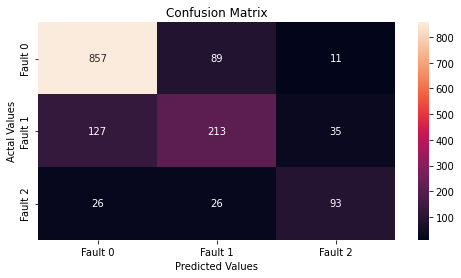

In [107]:
# Creating  a confusion matrix,which compares the y_test and y_pred
cm = confusion_matrix(y_test, y_pred3)
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm, index = ['Fault 0','Fault 1','Fault 2'], columns = ['Fault 0','Fault 1','Fault 2'])

#Plotting the confusion matrix
plt.figure(figsize=(8,4))
sns.heatmap(cm_df, annot=True,cbar=True, fmt='g')

plt.xlabel('Predicted Values')
plt.ylabel('Actal Values')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
loss2tr3 = log_loss(y_train.values,lgbm_rfe.predict_proba(X_train_rfe))
print("GBC: train loss {:.4f}".format(loss2tr3))
print('---------------------------------------------------------------')
loss2te3 = log_loss(y_test.values, lgbm_rfe.predict_proba(X_test_rfe))
print("GBC: test loss {:.4f}".format(loss2te3))

GBC: train loss 0.2509
---------------------------------------------------------------
GBC: test loss 0.5106


In [ ]:
#Predictions
y_pred3 = lgbm_rfe.predict(X_test_rfe)
report3 = classification_report(y_test,y_pred3,output_dict=True)
df_std3 = pd.DataFrame(report3).transpose()

In [ ]:
df_std3

precision    recall  f1-score      support
0              0.838772  0.913271  0.874437   957.000000
1              0.655518  0.522667  0.581602   375.000000
2              0.647059  0.606897  0.626335   145.000000
accuracy       0.784022  0.784022  0.784022     0.784022
macro avg      0.713783  0.680945  0.694125  1477.000000
weighted avg   0.773424  0.784022  0.775732  1477.000000

**Voting Classifier**

In [108]:
from sklearn.ensemble import VotingClassifier
from sklearn import model_selection

kfold = model_selection.KFold(n_splits=10, random_state=None)
# create the sub models
estimators = []
model1 = RandomForestClassifier()
estimators.append(('random forest', model1))
model2 = lgb.LGBMClassifier()
estimators.append(('lgbm', model2))
model3 = GradientBoostingClassifier()
estimators.append(('GBC', model3))
#model4 =  OneVsRestClassifier(XGBClassifier())
#estimators.append(('XGB', model4))
# create the ensemble model
ensemble = VotingClassifier(estimators,voting='soft')
results = model_selection.cross_val_score(ensemble, X_train_sca, y_train, cv=kfold,scoring='f1_macro')
print(results.mean())

0.7127402839097229


In [109]:
ensemble1 = ensemble.fit(X_train_sca,y_train) 

In [110]:
#Predictions
y_pred5 = ensemble1.predict(X_test_sca)

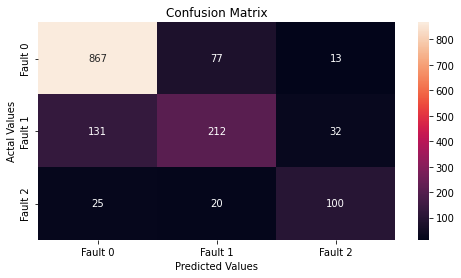

In [111]:
# Creating  a confusion matrix,which compares the y_test and y_pred
cm = confusion_matrix(y_test, y_pred5)
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm, index = ['Fault 0','Fault 1','Fault 2'], columns = ['Fault 0','Fault 1','Fault 2'])

#Plotting the confusion matrix
plt.figure(figsize=(8,4))
sns.heatmap(cm_df, annot=True,cbar=True, fmt='g')

plt.xlabel('Predicted Values')
plt.ylabel('Actal Values')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
loss2tr4 = log_loss(y_train.values, ensemble1.predict_proba(X_train_sca))
print("LGBM: train loss {:.4f}".format(loss2tr4))
print('---------------------------------------------------------------')
loss2te4 = log_loss(y_test.values, ensemble1.predict_proba(X_test_sca))
print("LGBM: test loss {:.4f}".format(loss2te4))

In [ ]:
#Predictions
y_pred4 = ensemble1.predict(X_test_sca)
report4 = classification_report(y_test,y_pred4,output_dict=True)
df_std4 = pd.DataFrame(report4).transpose()

In [ ]:
df_std4

In [ ]:
predict_test = ensemble1.predict_proba(test_sca)
pred_df1 = pd.DataFrame(predict_test,columns=['predict_0', 'predict_1', 'predict_2'])
Y3 = Y.reset_index()
results = pd.concat([Y3[['id']],pred_df1],axis=1)
results = results.set_index('id')  # set ID as index
results.head()

In [ ]:
results.to_csv('sub_ensemble.csv')

**Stacking Classifier**

In [ ]:
from sklearn.ensemble import StackingClassifier

In [ ]:
classifiers = [('rfc', model1),
               ('lgbm', model2),                             
               ('gbc', model3)]
lr = LogisticRegression()

In [ ]:
clf = StackingClassifier(estimators=classifiers, 
                         final_estimator=lr,
                         stack_method='auto',
                         n_jobs=-1,
                         passthrough=False)

In [ ]:
clf.fit(X_train_sca,y_train)

In [ ]:
loss2tr4 = log_loss(y_train.values, clf.predict_proba(X_train_sca))
print("Stacking Classifier: train loss {:.4f}".format(loss2tr4))
print('---------------------------------------------------------------')
loss2te4 = log_loss(y_test.values, clf.predict_proba(X_test_sca))
print("Stacking Classifier: test loss {:.4f}".format(loss2te4))

In [ ]:
#Predictions
y_pred4 = clf.predict(X_test_sca)
report4 = classification_report(y_test,y_pred4,output_dict=True)
df_std4 = pd.DataFrame(report4).transpose()

In [ ]:
df_std4

In [86]:
from hyperopt import tpe, hp, fmin, STATUS_OK,Trials
from hyperopt.pyll.base import scope

import warnings
warnings.filterwarnings("ignore")

In [87]:
from sklearn.metrics import f1_score, make_scorer, confusion_matrix, classification_report, precision_recall_curve, plot_precision_recall_curve, average_precision_score, auc

**Random Forest Classifier Hyperparameter Tuning Using Hyperopt**

In [ ]:
# defining the space for hyperparameter tuning
space = {'max_depth': hp.quniform("max_depth", 3, 18, 1),
         'n_estimators': hp.quniform('n_estimators', 25, 500, 25)
        }

In [ ]:
#defining function to optimize
def hyperparameter_tuning_rfc(space):
    rfc = RandomForestClassifier(n_estimators = int(space['n_estimators']),       #number of trees to use
                            max_depth = int(space['max_depth']),             #depth of tree
                            )                              
    
    evaluation = [(X_train_sca,y_train), (X_test_sca,y_test)]

    rfc.fit(X_train_sca,y_train)

    pred = rfc.predict(X_test_sca)
    f1 = f1_score(y_test, pred,average='macro')
    print("SCORE:", f1)
    loss = 1 - f1
    return {'loss': loss, 'status': STATUS_OK }

In [ ]:
# run the hyper paramter tuning
trials = Trials()
best = fmin(fn = hyperparameter_tuning_rfc,
            space = space,
            algo = tpe.suggest,
            max_evals = 100,
            trials = trials)

print (best)

In [ ]:
#initializing XGBoost Classifier with best model parameters
best_rfc = RandomForestClassifier(n_estimators = int(best['n_estimators']),
                            max_depth = int(best['max_depth'])
)
                    

In [ ]:
#fitting XGBoost Classifier with best model parameters to training data
best_rfc.fit(X_train_sca,y_train)

In [ ]:
#using the model to predict on the test set
y_pred = best_rfc.predict(X_test_sca)
#printing f1 score of test set predictions
print('The f1-score on the test data is: {0:.2f}'.format(f1_score(y_test, y_pred,average='macro')))

In [ ]:
loss2tr5 = log_loss(y_train.values, best_rfc.predict_proba(X_train_sca))
print("RFC: train loss {:.4f}".format(loss2tr5))
print('---------------------------------------------------------------')
loss2te5 = log_loss(y_test.values, best_rfc.predict_proba(X_test_sca))
print("RFC: test loss {:.4f}".format(loss2te5))

In [ ]:
#Predictions
y_pred5 = best_rfc.predict(X_test_sca)
report5 = classification_report(y_test,y_pred5,output_dict=True)
df_std5 = pd.DataFrame(report5).transpose()

In [ ]:
df_std5

In [ ]:
predict_rfc = best_rfc.predict_proba(test_sca)
pred_df = pd.DataFrame(predict_rfc,columns=['predict_0', 'predict_1', 'predict_2'])
Y3 = Y.reset_index()
results1 = pd.concat([Y3[['id']],pred_df],axis=1)
results1 = results1.set_index('id')  # set ID as index
results1.head()

In [ ]:
results1.to_csv('subrfc_hyp11.csv')

**LGBM Classifier Hyperparameter Tuning Using Hyperopt**

In [104]:
space = {
          'eta': hp.uniform("eta", 0.1, 1),
         'n_estimators': hp.quniform('n_estimators', 10, 300, 10),
         'max_depth': hp.quniform("max_depth", 3, 15, 1),
        'num_leaves': hp.quniform('num_leaves', 5, 200, 5),
        'reg_alpha': hp.quniform('reg_alpha', 0.0, 5.0,.05),
        'reg_lambda': hp.quniform('reg_lambda', 0.0, 8.0,0.4),
         #"learning_rate": hp.quniform("learning_rate", 0.005, 0.4, 0.01),
        #'bagging_freq': hp.quniform('bagging_freq', 1, 5, 1),
         "min_data_in_leaf": hp.choice('min_data_in_leaf', np.arange(20, 500,20, dtype=int)),
         'is_unbalance': hp.choice("is_unbalance", [True])
    }

In [105]:
#defining function to optimize
def hyperparameter_tuning_lgbm(space):
    lgbm = lgb.LGBMClassifier(n_estimators = int(space['n_estimators']),       #number of trees to use
                               eta = space['eta'],                              #learning rate  
                               max_depth = int(space['max_depth']),             #depth of trees
                               num_leaves = int(space['num_leaves']),           
                                reg_alpha = int(space['reg_alpha']),             #L1 regularization for weights
                              reg_lambda = space['reg_lambda'],                #L2 regularization for weights
                              #learning_rate = space['learning_rate'],
                              #bagging_freq = int(space['bagging_freq']),
                              min_data_in_leaf = int(space['min_data_in_leaf']),
                               nthread = -1)                                    #number of parallel threads used
    
    evaluation = [(X_train_sca,y_train), (X_test_sca,y_test)]

    lgbm.fit(X_train_sca,y_train,
            eval_set = evaluation,
            early_stopping_rounds = 10,
            verbose = False)

    pred = lgbm.predict(X_test_sca)
    f1 = f1_score(y_test, pred,average='macro')
    print("SCORE:", f1)
    loss = 1 - f1
    return {'loss': loss, 'status': STATUS_OK }

In [106]:
# run the hyper paramter tuning
trials = Trials()
best = fmin(fn = hyperparameter_tuning_lgbm,
            space = space,
            algo = tpe.suggest,
            max_evals = 100,
            trials = trials)

print (best)

SCORE:
0.6543990073645931
SCORE:
0.7190329217321278
SCORE:
0.7182746723080026
SCORE:
0.7141888125086986
SCORE:
0.7082937613734468
SCORE:
0.7005848077502081
SCORE:
0.7225775078560513
SCORE:
0.7162921903979941
SCORE:
0.7211854244142692
SCORE:
0.7007533706968055
SCORE:
0.7188845568660206
SCORE:
0.7074278973850859
SCORE:
0.7035703923905426
SCORE:
0.678904908433782
SCORE:
0.7083968238321079
SCORE:
0.7245495223567753
SCORE:
0.7011355925971827
SCORE:
0.7133822109667692
SCORE:
0.7035256527427437
SCORE:
0.727183902803839
SCORE:
0.7228491006641194
SCORE:
0.7213905242500701
SCORE:
0.7190385515530403
SCORE:
0.7025067837076032
SCORE:
0.7207977442243715
SCORE:
0.7231779543748086
SCORE:
0.7133507503605508
SCORE:
0.7074781231617783
SCORE:
0.7044025201738036
SCORE:
0.7242000169330639
SCORE:
0.7089241331647104
SCORE:
0.7225463621817084
SCORE:
0.7089485451213546
SCORE:
0.7298252741567262
SCORE:
0.7199377474510014
SCORE:
0.5238939573849076
SCORE:
0.7335779782203744
SCORE:
0.7149292512635407
SCORE:
0.72401

Each time hyperopt runs, it poduces new parameter and loss, hence selecting best loss and best parameters neglecting the previous parameters 

In [ ]:
#initializing XGBoost Classifier with best model parameters
#best_lgbm = lgb.LGBMClassifier(n_estimators = 180, eta = 0.45, max_depth = 13, num_leaves = 90, reg_alpha = 5.35,reg_lambda = 3.95, nthread = -1)

In [107]:
#initializing XGBoost Classifier with best model parameters
best_lgbm = lgb.LGBMClassifier(n_estimators = int(best['n_estimators']), 
                            eta = best['eta'], 
                            max_depth = int(best['max_depth']), 
                            num_leaves = int(best['num_leaves']), 
                            reg_alpha = int(best['reg_alpha']), 
                             reg_lambda = int(best['reg_lambda']),
                             min_data_in_leaf = int(best['min_data_in_leaf']),
                            nthread = -1)


In [108]:
#fitting LGBM Classifier with best model parameters to training data
best_lgbm.fit(X_train_sca,y_train)

LGBMClassifier(eta=0.3958946833274304, max_depth=8, min_data_in_leaf=1,
               n_estimators=160, nthread=-1, num_leaves=150, reg_alpha=2,
               reg_lambda=4)

In [109]:
#using the model to predict on the test set
y_pred_lgbm = best_lgbm.predict(X_test_sca)
#printing f1 score of test set predictions
print('The f1-score on the test data is: {0:.2f}'.format(f1_score(y_test, y_pred_lgbm,average='macro')))

The f1-score on the test data is: 0.72


In [110]:
loss2tr6 = log_loss(y_train.values, best_lgbm.predict_proba(X_train_sca))
print("LGBM: train loss {:.4f}".format(loss2tr6))
print('---------------------------------------------------------------')
loss2te6 = log_loss(y_test.values, best_lgbm.predict_proba(X_test_sca))
print("LGBM: test loss {:.4f}".format(loss2te6))

LGBM: train loss 0.1537
---------------------------------------------------------------
LGBM: test loss 0.4761


In [111]:
#Predictions
y_pred6 = best_lgbm.predict(X_test_sca)
report6 = classification_report(y_test,y_pred6,output_dict=True)
df_std6 = pd.DataFrame(report6).transpose()

In [112]:
df_std6

precision    recall  f1-score      support
0              0.854545  0.884013  0.869029   957.000000
1              0.628986  0.578667  0.602778   375.000000
2              0.704225  0.689655  0.696864   145.000000
accuracy       0.787407  0.787407  0.787407     0.787407
macro avg      0.729252  0.717445  0.722890  1477.000000
weighted avg   0.782520  0.787407  0.784528  1477.000000

In [113]:
#y_test =  y_test.values
y_pred1 = best_lgbm.predict(X_test_sca)

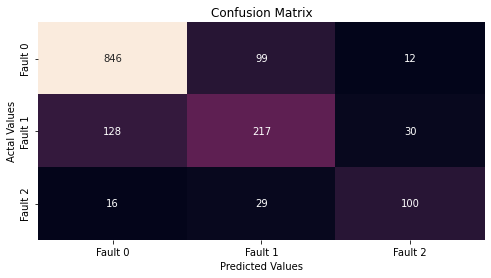

In [114]:
# Creating  a confusion matrix,which compares the y_test and y_pred
cm1 = confusion_matrix(y_test, y_pred1)
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df1 = pd.DataFrame(cm1,
                     index = ['Fault 0','Fault 1','Fault 2'], 
                     columns = ['Fault 0','Fault 1','Fault 2'])

#Plotting the confusion matrix
plt.figure(figsize=(8,4))
sns.heatmap(cm_df1, annot=True,cbar=False, fmt='g')

plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of events decile-wise 
 cum_resp_pct     : Cu

decile  prob_min  prob_max  ...  cum_non_resp_pct      KS   lift
0       1       1.0       2.0  ...             1.358  33.980  3.527
1       2       1.0       1.0  ...             5.538  47.996  2.671
2       3       1.0       1.0  ...            10.449  59.777  2.336
3       4       0.0       1.0  ...            20.690  58.107  1.969
4       5       0.0       0.0  ...            33.542  49.616  1.662
5       6       0.0       0.0  ...            47.231  38.784  1.432
6       7       0.0       0.0  ...            60.606  28.567  1.274
7       8       0.0       0.0  ...            73.668  19.415  1.163
8       9       0.0       0.0  ...            86.729   9.963  1.074
9      10       0.0       0.0  ...           100.000   0.000  1.000

[10 rows x 20 columns]

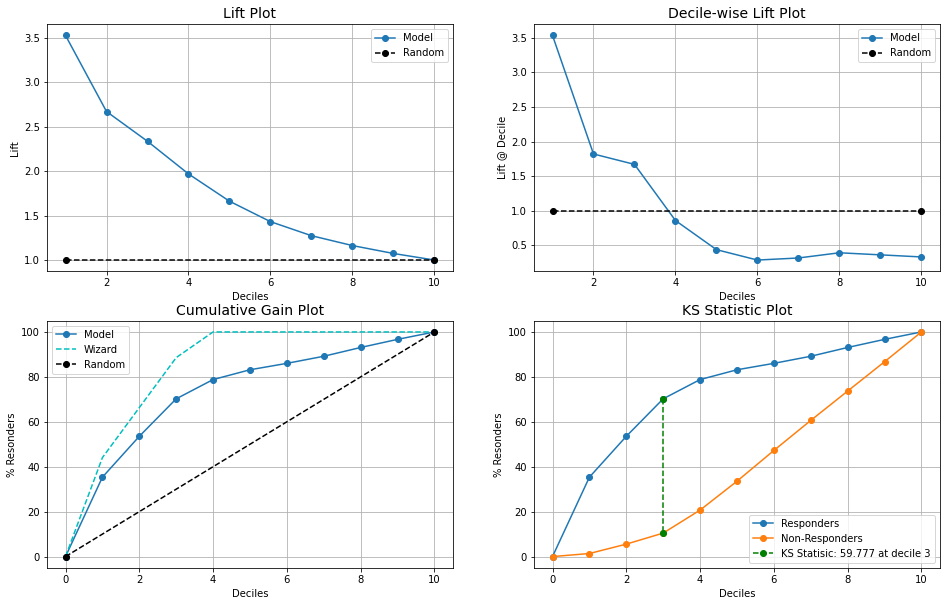

In [116]:
import kds
kds.metrics.report(y_test, y_pred1)

In [ ]:
predict_lgbm = best_lgbm.predict_proba(test_sca)
pred_df = pd.DataFrame(predict_lgbm,columns=['predict_0', 'predict_1', 'predict_2'])
Y3 = Y.reset_index()
results1 = pd.concat([Y3[['id']],pred_df],axis=1)
results1 = results1.set_index('id')  # set ID as index
results1.head()

In [ ]:
results1.to_csv('LGBMHyp-3.csv')

In [129]:
#initializing XGBoost Classifier with best model parameters
best_lgbm2 = lgb.LGBMClassifier(n_estimators = 180, eta = 0.45, max_depth = 13, num_leaves = 90, reg_alpha = 5.35,reg_lambda = 3.95, nthread = -1)

In [130]:
#fitting LGBM Classifier with best model parameters to training data
best_lgbm2.fit(X_train_sca,y_train)

LGBMClassifier(eta=0.45, max_depth=13, n_estimators=180, nthread=-1,
               num_leaves=90, reg_alpha=5.35, reg_lambda=3.95)

In [131]:
#using the model to predict on the test set
y_pred_lgbm2 = best_lgbm2.predict(X_test_sca)
#printing f1 score of test set predictions
print('The f1-score on the test data is: {0:.2f}'.format(f1_score(y_test, y_pred_lgbm2,average='macro')))

The f1-score on the test data is: 0.72


LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of events decile-wise 
 cum_resp_pct     : Cu

decile  prob_min  prob_max  ...  cum_non_resp_pct      KS   lift
0       1       1.0       2.0  ...             1.672  33.065  3.467
1       2       1.0       1.0  ...             5.852  46.930  2.634
2       3       1.0       1.0  ...            10.449  60.228  2.351
3       4       0.0       1.0  ...            22.048  54.343  1.909
4       5       0.0       0.0  ...            34.587  46.616  1.623
5       6       0.0       0.0  ...            47.858  36.653  1.407
6       7       0.0       0.0  ...            61.233  26.436  1.252
7       8       0.0       0.0  ...            73.877  18.604  1.156
8       9       0.0       0.0  ...            87.147   8.793  1.065
9      10       0.0       0.0  ...           100.000   0.000  1.000

[10 rows x 20 columns]

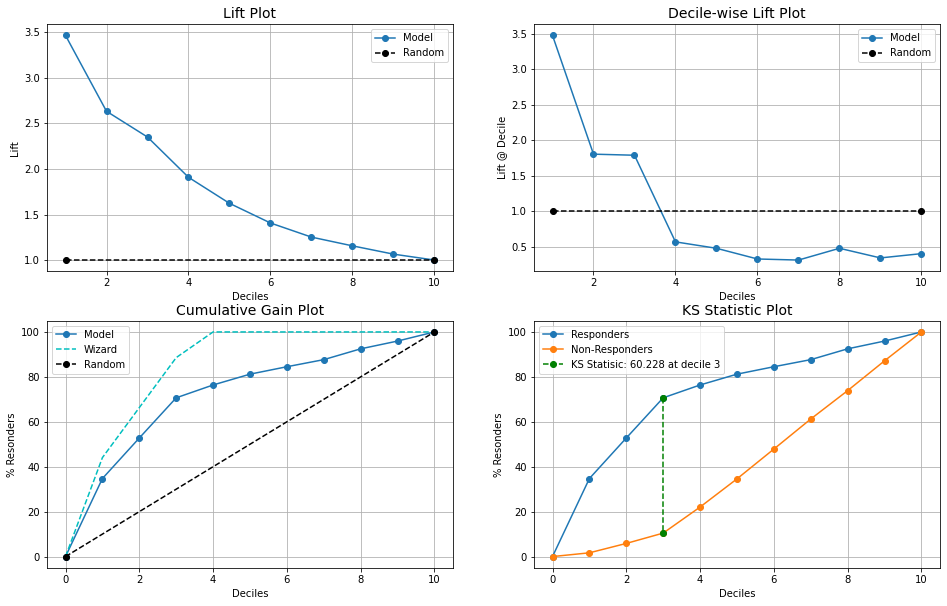

In [132]:
import kds
kds.metrics.report(y_test, y_pred_lgbm2)

In [117]:
#initializing XGBoost Classifier with best model parameters
best_lgbm1 = lgb.LGBMClassifier(n_estimators = 180, eta = 0.45, max_depth = 13, num_leaves = 90, reg_alpha = 5.35,reg_lambda = 3.95, nthread = -1)

In [120]:
#fitting LGBM Classifier with best model parameters to training data
best_lgbm1.fit(X5,y)

LGBMClassifier(eta=0.45, max_depth=13, n_estimators=180, nthread=-1,
               num_leaves=90, reg_alpha=5.35, reg_lambda=3.95)

LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of events decile-wise 
 cum_resp_pct     : Cu

decile  prob_min  prob_max  ...  cum_non_resp_pct      KS   lift
0       1       1.0       2.0  ...             0.836  34.653  3.542
1       2       1.0       1.0  ...             1.881  54.961  2.836
2       3       1.0       1.0  ...             3.657  73.035  2.551
3       4       0.0       1.0  ...            17.032  63.720  2.018
4       5       0.0       0.0  ...            30.825  53.386  1.683
5       6       0.0       0.0  ...            45.037  41.279  1.437
6       7       0.0       0.0  ...            59.352  29.069  1.263
7       8       0.0       0.0  ...            72.727  20.205  1.161
8       9       0.0       0.0  ...            86.729   9.060  1.064
9      10       0.0       0.0  ...           100.000   0.000  1.000

[10 rows x 20 columns]

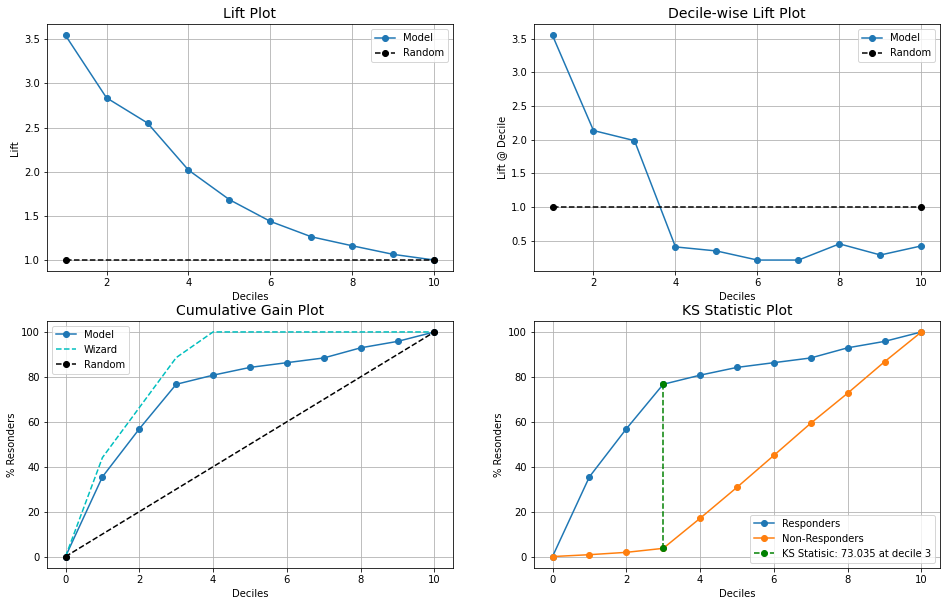

In [124]:
kds.metrics.report(y_test, y_pred_bestlgbm)

For this submission achieved a log loss of 0.5142 which is among top-300 in the kaggle competition

In [ ]:
predict_lgbm = best_lgbm1.predict_proba(Y5)
pred_df = pd.DataFrame(predict_lgbm,columns=['predict_0', 'predict_1', 'predict_2'])
Y3 = Y.reset_index()
results1 = pd.concat([Y3[['id']],pred_df],axis=1)
results1 = results1.set_index('id')  # set ID as index
results1.head()

In [ ]:
predict_lgbm 

In [ ]:
results1.to_csv('LGBMHyp.csv')

In [127]:
import joblib
joblib.dump(best_lgbm1, 'lgbmhypp.pkl')

['lgbmhypp.pkl']

In [128]:
# Save the model
import pickle 
# save the model to disk
path = ' '
modelname = path + 'lgbmhypp.pkl'
pickle.dump(best_lgbm1, open(modelname, 'wb'))

In [ ]:
loss2tr6 = log_loss(y_train.values, best_lgbm.predict_proba(X_train_sca))
print("LGBM: train loss {:.4f}".format(loss2tr6))
print('---------------------------------------------------------------')
loss2te6 = log_loss(y_test.values, best_lgbm.predict_proba(X_test_sca))
print("LGBM: test loss {:.4f}".format(loss2te6))

In [ ]:
#Predictions
y_pred6 = best_lgbm.predict(X_test_sca)
report6 = classification_report(y_test,y_pred6,output_dict=True)
df_std6 = pd.DataFrame(report6).transpose()

In [ ]:
df_std6

In [ ]:
predict_lgbm = best_lgbm.predict_proba(Y5)
pred_df = pd.DataFrame(predict_lgbm,columns=['predict_0', 'predict_1', 'predict_2'])
Y3 = Y.reset_index()
results1 = pd.concat([Y3[['id']],pred_df],axis=1)
results1 = results1.set_index('id')  # set ID as index
results1.head()

In [ ]:
results1.to_csv('lgbm_hypnew6.csv')

In [ ]:
import joblib

In [ ]:
#Save Trained Model Using joblib
#joblib.dump(best_lgbm, 'lgbmhyp_joblib')

In [ ]:
#Load Saved Model
lgbm_best = joblib.load('lgbmhyp_joblib')

EvalML is an AutoML library which builds, optimizes, and evaluates machine learning pipelines using domain-specific objective functions.
Key Functionality

Automation: Makes machine learning easier. Avoid training and tuning models by hand. Includes data quality checks, cross-validation and more.

Data Checks: Catches and warns of problems with your data and problem setup before modeling.

End-to-end: Constructs and optimizes pipelines that include state-of-the-art preprocessing, feature engineering, feature selection, and a variety of modeling techniques.

Model Understanding: Provides tools to understand and introspect on models, to learn how they'll behave in your problem domain.

Domain-specific: Includes repository of domain-specific objective functions and an interface to define your own.

Reference:¶

https://github.com/alteryx/evalml

https://github.com/alteryx/evalml

https://evalml.alteryx.com/en/stable/install.html

In [ ]:
!pip install evalml

In [ ]:
import evalml

In [ ]:
X_train1, X_test1, y_train1, y_test1 = evalml.preprocessing.split_data(X, y, problem_type='multiclass',test_size=0.2)

In [ ]:
evalml.objectives.utils.get_core_objective_names()

Balanced Accuracy is also useful for multiclass classification. Here, BA is the average of Recall obtained on each class, i.e. the macro average of recall scores per class. 

In [ ]:
from evalml import AutoMLSearch
automl = AutoMLSearch(X_train=X_train1, y_train=y_train1, problem_type='multiclass', objective='log loss multiclass', additional_objectives=['f1 macro','balanced accuracy multiclass'],
                      max_iterations=10, verbose=True)
automl.search()

In [ ]:
automl.rankings

In [ ]:
automl.describe_pipeline(automl.rankings.iloc[0]["id"])

In [ ]:
best_pipeline = automl.best_pipeline

In [ ]:
best_pipeline 

In [ ]:
# get the score on holdout data
best_pipeline.score(X_test1, y_test1,  objectives=['f1 macro','balanced accuracy multiclass'])

In [ ]:
#Predictions
y_pred6 = best_pipeline.predict(X_test1)
report6 = classification_report(y_test1,y_pred6,output_dict=True)
df_std6 = pd.DataFrame(report6).transpose()

In [ ]:
df_std6

In [ ]:
#visualizing best pipeline flow 
best_pipeline.graph()

In [ ]:
best_pipeline.graph_feature_importance(importance_threshold=0)

In [ ]:
predictions_test = best_pipeline.predict_proba(Y)

By using Auto ML library 'Evalml', achieved Public logloss of 0.53 on leadership board

In [ ]:
predictions_test.columns = ['predict_0', 'predict_1', 'predict_2']
predictions_test 

In [ ]:
predictions_test.to_csv('XGB_evaml.csv')

In [ ]:
best_pipeline.save("XGBModel.pkl")

Loading the Model

In [ ]:
check_model=automl.load('XGBModel.pkl')

**Model Interpretability Using SHAP**

In [ ]:
!pip install shap

In [ ]:
 from sklearn.tree import export_graphviz
 import shap 
 import graphviz
 sns.set_style('darkgrid') 

In [ ]:
 # define target as pandas series
 y_s = pd.Series(y)

In [ ]:
 # split data into train and test sets
 X_train, X_test, y_train, y_test = train_test_split(X, y_s, test_size=0.2, random_state=1)

In [ ]:
lgbm1 = lgbm.fit(X_train_sca,y_train)

In [ ]:
# Initialize JavaScript visualizations in notebook environment
shap.initjs()
# Define a tree explainer for the built model
explainer = shap.TreeExplainer(lgbm1)

In [ ]:
shap_values = explainer.shap_values(X)

In [ ]:
shap_train = explainer.shap_values(X_train)
shap_test = explainer.shap_values(X_test)

In [ ]:
print(shap_train[0].shape)

(5904, 37)


In [ ]:
print(shap_test[1].shape)

(1477, 37)


**SHAP Force Plot**

Force plots can be made interactive by plotting it with more data points. Here we plotted it with all of the test data. By hovering mouse pointer over the regions of plot, we can observe shap values interactively.

Dropdown options are shown in the interactive plot to select features of interest. It gives a better understanding on how two different features interact with each other in predicting the outputs. It should be noted that, in our example, the red and blue colors show positive and negative predictions respectively.

In [ ]:
 # obtain shap values for the test data
 # Initialize JavaScript visualizations in notebook environment
 shap.initjs()
 shap.force_plot(explainer.expected_value[1], shap_test[1], X_test)

In [ ]:
shap_test

[array([[-0.01288916, -0.35513088,  0.28648744, ..., -0.00049471,
          0.00289488, -0.17678538],
        [-0.2673625 , -0.30864466,  0.00549281, ...,  0.06048492,
          0.00526622, -0.1074892 ],
        [-0.18656056, -0.37380032,  0.25690201, ...,  0.00964299,
          0.01332869, -0.07171287],
        ...,
        [-0.04184857, -0.354113  ,  0.37280299, ...,  0.01733608,
          0.00565242, -0.0094931 ],
        [-0.1261581 , -0.36431107,  0.00294821, ...,  0.03877614,
          0.00141556, -0.15190036],
        [-0.15919066, -0.34518055,  0.22859499, ..., -0.0073415 ,
          0.00837497, -0.14509339]]),
 array([[-0.03239618,  0.08922896,  0.09139568, ...,  0.25447617,
         -0.04462665,  0.10588901],
        [-0.03173472,  0.0932849 ,  0.07035323, ...,  0.00420461,
         -0.0064961 ,  0.04878285],
        [-0.06668208,  0.08917328,  0.12163149, ...,  0.0387629 ,
         -0.03778265,  0.12845526],
        ...,
        [-0.08838349,  0.03214833,  0.1070905 , ...,  

**SHAP Summary Plot**

Rather than use a typical feature importance bar chart, we use a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset. Features are sorted by the sum of the SHAP value magnitudes across all samples. 

Note that when the scatter points don’t fit on a line they pile up to show density, and the color of each point represents the feature value of that individual.

**Ref**: https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20LightGBM.html

Summary plots are easy-to-read visualizations which bring the whole data to a single plot. All of the features are listed in y-axis in the rank order, the top one being the most contributor to the predictions and the bottom one being the least or zero-contributor. Shap values are provided in the x-axis. As we discussed already, a value of zero represents no contribution whereas contributions increase as the shap value moves away from zero. Each circular dot in the plot represents a single data point. Color of the dot denotes the value of that corresponding feature.

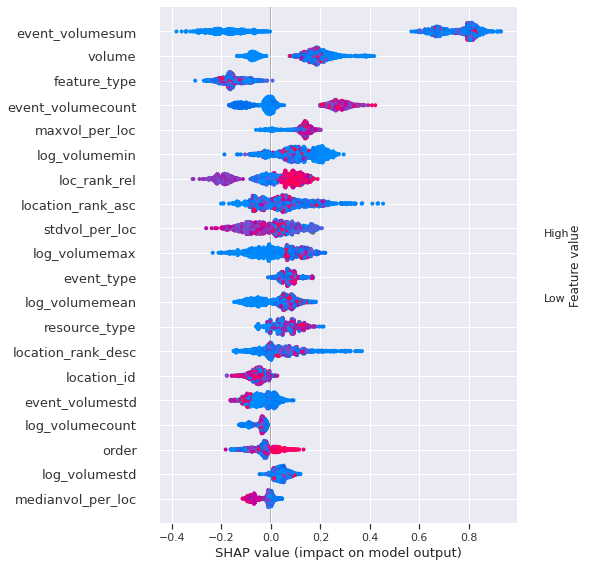

In [ ]:
shap.summary_plot(shap_test[1],X_test,plot_type='dot')

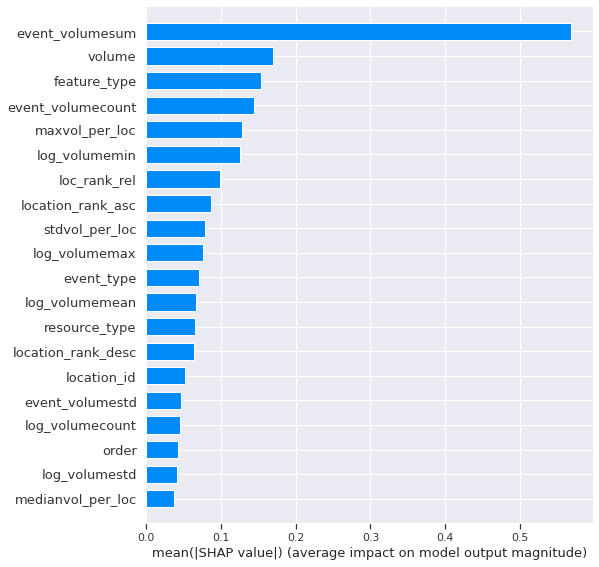

In [ ]:
shap.summary_plot(shap_test[1],X_test,plot_type='bar')

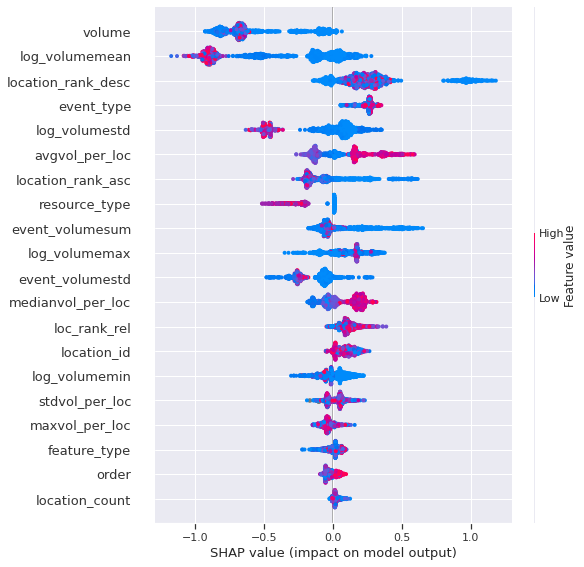

In [ ]:
shap.summary_plot(shap_test[2],X_test,plot_type='dot')

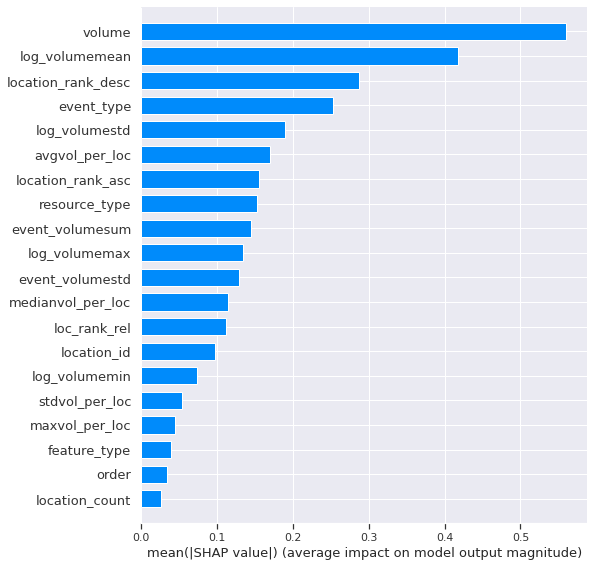

In [ ]:
shap.summary_plot(shap_test[2],X_test,plot_type='bar')

Summary plot can also be visualized as a bar plot for quick reading with minimum details.

It is clearly observed that top 20 ranked features alone contribute to the model’s predictions.

In this plot, the impact of a feature on the classes is stacked to create the feature importance plot

In the example below we can see that the class 1 hardly uses the features stdvol_per_loc,logvolume_count,event_volcount,log_volumemean. We can also see that the class 2 and class 0 uses the same feature - event_volum equally. That is the reason the confusion between them is relatively high. In order to separate better between the class 2  and class 0 , one needs to generate new features that uniquely be dedicated towards these classes.

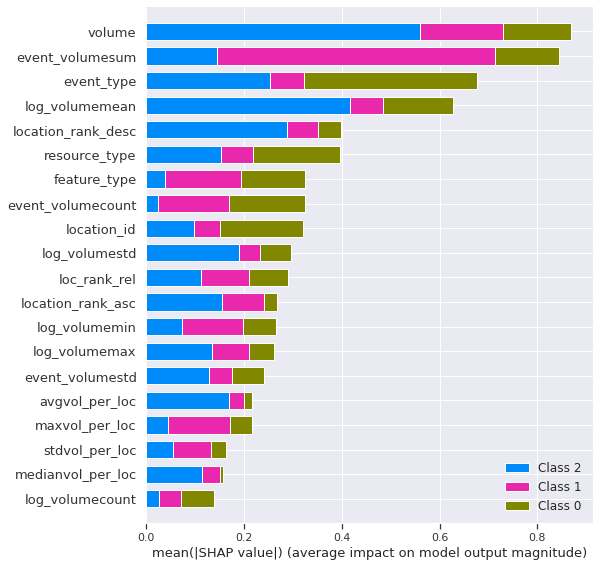

In [ ]:
shap.summary_plot(shap_test, X_test, plot_type='bar')

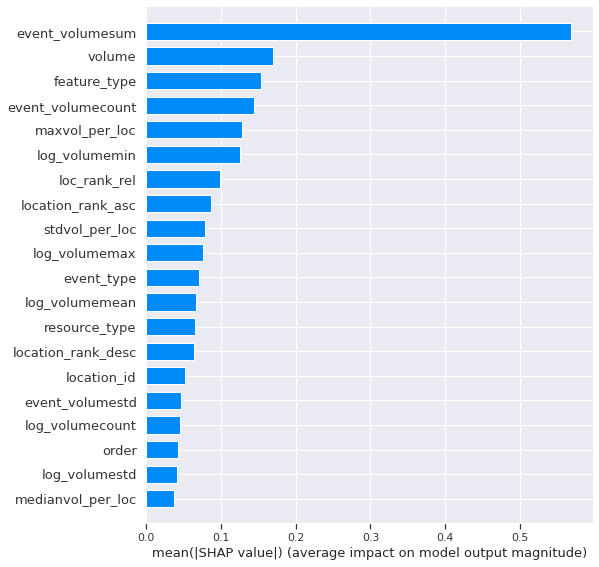

In [ ]:
shap.summary_plot(shap_test[1], X_test, plot_type='bar')

In [ ]:
X_df['fault_severity']

0       1
1       0
2       1
3       1
4       0
       ..
7376    0
7377    0
7378    2
7379    0
7380    0
Name: fault_severity, Length: 7381, dtype: int64

Understanding Interactions

In [ ]:
X_df

id  fault_severity  ...  location_count  loc_rank_rel
0     14121               1  ...              33          0.30
1      9320               0  ...              49          0.59
2     14394               1  ...               5          0.60
3      8218               1  ...              33          0.73
4     14804               0  ...              12          1.00
...     ...             ...  ...             ...           ...
7376    870               0  ...               5          0.40
7377  18068               0  ...               4          0.25
7378  14111               2  ...              33          0.82
7379  15189               0  ...              24          0.17
7380  17067               0  ...              22          0.68

[7381 rows x 39 columns]

**Model Interpreability Using SHAP**

In [ ]:
!pip install lime

In [ ]:
import lime
from lime import lime_tabular

interpretor = lime_tabular.LimeTabularExplainer(
    X_test.values,
    feature_names=X_test.columns,
    mode='classification'
)

In [ ]:
lime_svm_explainer =\
lime.lime_tabular.LimeTabularExplainer(X_test.values,\
feature_names=X_test.columns,\
categorical_features=list(range(3,44)),\
class_names=['Not Highly Recomm.', 'Highly Recomm.'])

In [ ]:
X_test.iloc[5]

location_id           564.000000
event_type             11.000000
resource_type           8.000000
severity_type           2.000000
volume                 11.000000
feature_type          226.000000
log_volumecount         2.000000
log_volumemin           1.000000
log_volumemean          5.500000
log_volumemax          10.000000
log_volumestd           6.363961
log_volumesum          11.000000
event_volumecount       2.000000
event_volumemin         1.000000
event_volumemean        5.500000
event_volumemax        10.000000
event_volumestd         6.363961
event_volumesum        11.000000
sev_volumecount         2.000000
sev_volumemin           1.000000
sev_volumemean          5.500000
sev_volumemax          10.000000
sev_volumestd           6.363961
sev_volumesum          11.000000
log_volume              2.397895
avgvol_per_loc          2.397895
maxvol_per_loc          2.397895
minvol_per_loc          2.397895
medianvol_per_loc       2.397895
stdvol_per_loc               NaN
order     

**Voting Classifier Using Hyperparameter Tuned Ensmeble Models: LGBM HYP & LGB, VAR THRESOLDIG**

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn import model_selection

kfold = model_selection.KFold(n_splits=10, random_state=None)
# create the sub models
estimators_hyp2 = []
estimators_hyp2.append(('lgbm var thr', lgbm_var))
estimators_hyp2.append(('lgbm hyp', lgbm_best))
# create the ensemble model
ensemble_hyp2 = VotingClassifier(estimators_hyp2,voting='soft')
results_hyp2 = model_selection.cross_val_score(ensemble_hyp2, X_train_sca, y_train, cv=kfold,scoring='f1_macro')
print(results_hyp2.mean())

In [ ]:
ensemblehyp = ensemble_hyp2.fit(X_train_sca,y_train) 

In [ ]:
loss2tr7 = log_loss(y_train.values, ensemblehyp.predict_proba(X_train_sca))
print("Ensemble_hyp: train loss {:.4f}".format(loss2tr7))
print('---------------------------------------------------------------')
loss2te7 = log_loss(y_test.values, ensemblehyp.predict_proba(X_test_sca))
print("Ensemble_hyp: test loss {:.4f}".format(loss2te7))

In [ ]:
#Predictions
y_pred7 = ensemblehyp.predict(X_test_sca)
report7 = classification_report(y_test,y_pred7,output_dict=True)
df_std7 = pd.DataFrame(report7).transpose()

In [ ]:
df_std7

In [ ]:
predict_ensemble = ensemblehyp.predict_proba(test_sca)
pred_df = pd.DataFrame(predict_ensemble,columns=['predict_0', 'predict_1', 'predict_2'])
Y3 = Y.reset_index()
results3 = pd.concat([Y3[['id']],pred_df],axis=1)
results3 = results3.set_index('id')  # set ID as index
results3.head()

In [ ]:
results3.to_csv('subensemble1.csv')

In [ ]:
#Save Trained Model Using joblib
joblib.dump(ensemblehyp, 'ensemblehyp_joblib')

In [ ]:
#Load Saved Model
ensemble_best = joblib.load('ensemblehyp_joblib')

***Neural Network Using Softmax Activation Function ***

In [ ]:
# first neural network with keras tutorial
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

In [ ]:
# define the keras model
model = Sequential()
model.add(Dense(16, input_dim=483, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.03))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.04))
model.add(Dense(1, activation='softmax'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [ ]:
...
# fit the keras model on the dataset
model.fit(X_train_sca, y_train, epochs=10, batch_size=2)

In [ ]:
# evaluate the keras model
accuracy = model.evaluate(X_test_sca, y_test)
print('Accuracy: %.2f' % (accuracy*100))

In [ ]:
"""
import joblib
joblib.dump(lgbm, 'lgbm_joblib')

lgbm_model  = joblib.load('lgbm_joblib')
"""

**Prinicpal Compenent Analysis**

In [ ]:
# Calculating Eigenvectors and eigenvalues of Cov matirx
mean_vec = np.mean(X_train_transformed_sca_copy, axis=0)
cov_mat = np.cov(X_train_transformed_sca_copy.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
# Create a list of (eigenvalue, eigenvector) tuples
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the eigenvalue, eigenvector pair from high to low
eig_pairs.sort(key = lambda x: x[0], reverse= True)

# Calculation of Explained Variance from the eigenvalues
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

In [ ]:
# Find the eigenvector beyond which 90% of the data is explained
[ n for n,i in enumerate(cum_var_exp) if i>95 ][0]

6

In [ ]:
from sklearn.decomposition import PCA

# Call the PCA method with 165 components. 
pca = PCA(n_components=165)
pca.fit(X_train_transformed_sca)
X_165d_train = pca.transform(X_train_transformed_sca)
X_165d_test = pca.transform(X_test_transformed_sca)

NameError: ignored

In [ ]:
print(X_165d_train.shape,y_train.shape)

NameError: ignored

In [ ]:
lgbm.fit(X_165d_train, y_train)

In [ ]:
#Predictions
y_pred = lgbm.predict(X_165d_test)
report2 = classification_report(y_test,y_pred,output_dict=True)
df_std = pd.DataFrame(report2).transpose()

In [ ]:
df_std

In [ ]:
X_165d_train = pd.DataFrame(X_165d_train)
X_165d_test = pd.DataFrame(X_165d_test)

In [ ]:
loss2tr = log_loss(y_train.values, lgbm.predict_proba(X_165d_train.values))
print("Random forest: train loss {:.4f}".format(loss2tr))
print('---------------------------------------------------------------')
loss2te = log_loss(y_test.values, lgbm.predict_proba(X_165d_test.values))
print("Random forest: test loss {:.4f}".format(loss2te))
print('---------------------------------------------------------------')

**Using only 2 pricipal components torepresent data in 3D**

In [ ]:
from sklearn.decomposition import PCA

# Call the PCA method with 2 components. 
pca = PCA(n_components=2)
pca.fit(X_train_transformed_sca1)
X_2d_train = pca.transform(X_train_transformed_sca1)
X_2d_test = pca.transform(X_test_transformed_sca1)

In [ ]:
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train1,X_test1, y_train1, y_test1 = train_test_split(X_df, y, stratify=y, test_size=0.2)

In [ ]:
PCA_df = pd.DataFrame(data = X_2d_train, columns = ['PC1', 'PC2'])

In [ ]:
X1 = X_df.iloc[0:5904,[1]]

In [ ]:
PCA_df = pd.concat([PCA_df, X1['fault_severity']], axis = 1)

In [ ]:
PCA_df 

In [ ]:
!pip install chart-studio

In [ ]:
!pip install plotly --upgrade

In [ ]:
#Plotly Interactive Version
import plotly
#from chart_studio import plotly
import plotly.offline as pyoff
import plotly.graph_objs as go
import plotly.graph_objs as go
#plotly.offline.init_notebook_mode()

trace1 = go.Scatter3d(
    x=PCA_df.PC1,
    y=PCA_df.PC2,
    z=PCA_df.fault_severity,
    mode='markers',
    marker=dict(
        size=12,
        color=PCA_df.fault_severity,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)

data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

In [ ]:
# ploting the 2d data points with seaborn
import seaborn as sn
sn.FacetGrid(PCA_df, hue="fault_severity", size=6).map(plt.scatter, 'PC1', 'PC2').add_legend()
plt.show()